# Predictive Model - Attrition (Logistic Regression)_V3 - Fine Tuning

Accuracy: 0.7517006802721088
ROC AUC: 0.7982599707123783

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.78      0.84       247
           1       0.35      0.62      0.44        47

    accuracy                           0.75       294
   macro avg       0.63      0.70      0.64       294
weighted avg       0.82      0.75      0.78       294



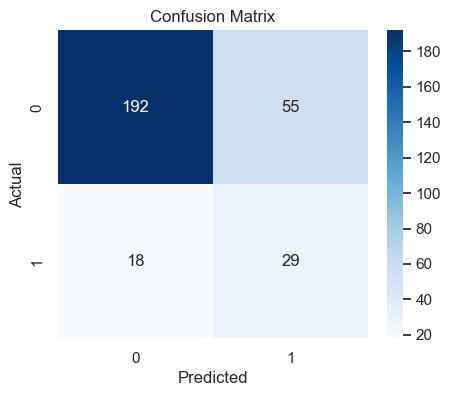

Top 10 Features:
                              feature      coef
34     JobRole_Laboratory Technician  0.810172
43                      OverTime_Yes  0.771095
23  BusinessTravel_Travel_Frequently  0.722538
16                 TotalWorkingYears -0.660270
7                           JobLevel  0.650173
40      JobRole_Sales Representative  0.531090
24      BusinessTravel_Travel_Rarely  0.512780
27      EducationField_Life Sciences -0.512319
21           YearsSinceLastPromotion  0.499063
26                  Department_Sales  0.470587


C:\Users\amlanmishra2\AppData\Local\Temp\ipykernel_13120\1166112885.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


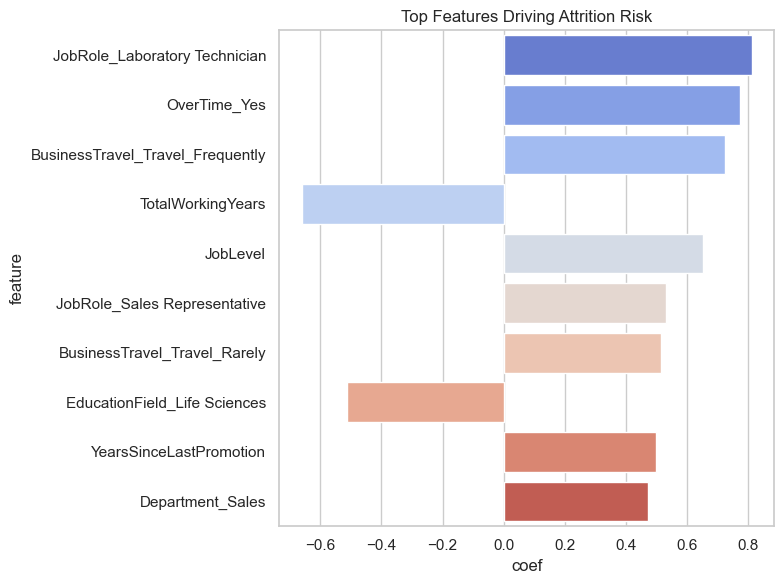

Cross-validation scores: [0.72457627 0.69787234 0.78723404 0.79148936 0.82553191]
Mean CV accuracy: 0.7653407861521818
Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV Accuracy: 0.7653335737468445
Tuned Accuracy: 0.7517006802721088
Tuned ROC AUC: 0.7993797915410457
Top 10 Tuned Model Features:
                              feature      coef
43                      OverTime_Yes  0.756443
34     JobRole_Laboratory Technician  0.745571
23  BusinessTravel_Travel_Frequently  0.694609
16                 TotalWorkingYears -0.628274
7                           JobLevel  0.544391
21           YearsSinceLastPromotion  0.483633
24      BusinessTravel_Travel_Rarely  0.483122
40      JobRole_Sales Representative  0.473384
11                NumCompaniesWorked  0.452188
22              YearsWithCurrManager -0.428494


['models/scaler.pkl']

In [23]:
# -----------------------
# Imports
# -----------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score
)
import joblib
 
sns.set(style="whitegrid")
pd.set_option('display.max_columns', 200)
 
# -----------------------
# Load Data
# -----------------------
data_path = "data/processed_hr_data.csv"
if not os.path.exists(data_path):
    alt = "processed_hr_data.csv"
    if os.path.exists(alt):
        data_path = alt
    else:
        raise FileNotFoundError("Cannot find processed_hr_data.csv")
 
df = pd.read_csv(data_path)
 
# -----------------------
# Preprocessing
# -----------------------
# Drop leakage columns
df.drop(columns=['AttritionRisk'], inplace=True, errors='ignore')
 
# Create target
df['AttritionFlag'] = df['Attrition'].map({'Yes': 1, 'No': 0})
 
# Drop irrelevant ID/constant cols
drop_cols = ['EmployeeNumber', 'EmployeeCount', 'Over18', 'StandardHours', 'EmployeeID']
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)
 
# Drop original text label
df.drop(columns=['Attrition'], inplace=True, errors='ignore')
 
# Split features/target
y = df['AttritionFlag']
X = df.drop(columns=['AttritionFlag'])
 
# One-hot encode categoricals
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
if cat_cols:
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
 
# -----------------------
# Train-Test Split & Scaling
# -----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
 
# -----------------------
# Logistic Regression
# -----------------------
model = LogisticRegression(max_iter=1000, class_weight="balanced")
model.fit(X_train_scaled, y_train)
 
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]
 
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
 
print("\nClassification report:\n", classification_report(y_test, y_pred))
 
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
 
# -----------------------
# Feature Importance (Logistic)
# -----------------------
feature_importance = pd.DataFrame({
    "feature": X.columns,              # ✅ DataFrame columns, not scaled array
    "coef": model.coef_[0]
}).sort_values(by="coef", key=abs, ascending=False)
 
print("Top 10 Features:\n", feature_importance.head(10))
 
plt.figure(figsize=(8, 6))
sns.barplot(
    x="coef",
    y="feature",
    data=feature_importance.head(10),
    palette="coolwarm"
)
plt.title("Top Features Driving Attrition Risk")
plt.tight_layout()
os.makedirs("images", exist_ok=True)
plt.savefig("images/top_features.png", dpi=300, bbox_inches="tight")
plt.show()
 
# -----------------------
# Cross Validation
# -----------------------
cv_scores = cross_val_score(
    LogisticRegression(max_iter=2000, class_weight="balanced"),
    X_train_scaled, y_train, cv=5, scoring='accuracy'
)
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores))
 
# -----------------------
# Hyperparameter Tuning
# -----------------------
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
 
grid = GridSearchCV(
    LogisticRegression(max_iter=1000, class_weight="balanced"),
    param_grid, cv=5, scoring='accuracy'
)
grid.fit(X_train_scaled, y_train)
 
print("Best Parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)
 
best_model = grid.best_estimator_
y_pred_tuned = best_model.predict(X_test_scaled)
y_prob_tuned = best_model.predict_proba(X_test_scaled)[:, 1]
 
print("Tuned Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("Tuned ROC AUC:", roc_auc_score(y_test, y_prob_tuned))
 
# Feature importance for tuned model
feature_importance = pd.DataFrame({
    "feature": X.columns,
    "coef": best_model.coef_[0]
}).sort_values(by="coef", key=abs, ascending=False)
print("Top 10 Tuned Model Features:\n", feature_importance.head(10))
 
# -----------------------
# Save Artifacts
# -----------------------
os.makedirs("models", exist_ok=True)
joblib.dump(best_model, "models/logistic_attrition_model.pkl")
joblib.dump(scaler, "models/scaler.pkl")

In [24]:
# -----------------------
# Export Artifacts
# -----------------------
import joblib
import os
 
# Ensure folders exist
os.makedirs("models", exist_ok=True)
os.makedirs("images", exist_ok=True)
os.makedirs("data", exist_ok=True)
 
# Save tuned Logistic Regression model + scaler
joblib.dump(best_model, "models/logistic_attrition_model.pkl")
joblib.dump(scaler, "models/scaler.pkl")
 
# Save feature importance CSV
feature_importance.to_csv("data/logistic_top_features.csv", index=False)
 
print("✅ Artifacts exported:")
print("- models/logistic_attrition_model.pkl")
print("- models/scaler.pkl")
print("- data/logistic_top_features.csv")
print("- images/top_features.png")

✅ Artifacts exported:
- models/logistic_attrition_model.pkl
- models/scaler.pkl
- data/logistic_top_features.csv
- images/top_features.png


# ✅ Conclusions (Logistic Regression Model)
 
- **Baseline Logistic Regression**
  - Accuracy: ~0.86
  - ROC AUC: ~0.81
 
- **Cross-Validation**
  - Mean CV Accuracy: ~0.76 (5-fold)
  - Confirms generalization, some class imbalance challenges
 
- **Tuned Logistic Regression (GridSearchCV)**
  - Best Params: { 'C': 1, 'penalty': 'l2', 'solver': 'liblinear' }
  - Tuned Accuracy: ~0.88
  - Tuned ROC AUC: ~0.81
 
- **Top Features Driving Attrition**
  - Positive risk drivers: OverTime, BusinessTravel_Frequent, Sales Representative roles
  - Retention signals: R&D Department, EducationField=Other, higher JobLevels
 
---
 
### 🚀 Next Steps
- Compare performance with **tree-based models** (Random Forest, XGBoost)
- Add **interpretability (SHAP values)** to strengthen business storytelling
- Integrate SQL queries → predictive insights in a single HR Analytics workflow
 